In [1]:
### Defining Environment variables pointing to user folders
from os import environ,path

environ.setdefault('HOME_DIR', "/workarea/local/shared/"+ environ['USERNAME'])
environ.setdefault('TRAINING_DATA_FOLDER',"/j100")
environ.setdefault('MODEL_STORAGE',environ['HOME_DIR']+"/trained_models"+environ['TRAINING_DATA_FOLDER'])

feather_folder = environ['HOME_DIR']+"/lb-trksim-train/notebooks/feather_folder"+environ['TRAINING_DATA_FOLDER']
environ.setdefault("TEST_DATA"      , feather_folder+"/acceptance-test")

environ.setdefault("MODEL_VARIANT","v1")
default_input_model = "/models/acceptance/saved_model.pb"
if environ['MODEL_VARIANT'] != '':
    model_path,model_name = path.split(default_input_model)
    default_input_model   = path.join(model_path,environ['MODEL_VARIANT'],model_name)
    
environ.setdefault('INPUT_MODEL',environ['MODEL_STORAGE']+default_input_model)

_ = environ.setdefault('NB_EXPORT',"True") # whether export notebooks

# Validation of the acceptance model
##### Tested on environment `LHCb Analysis Facility` from [landerlini/lhcbaf:v0p8](https://hub.docker.com/r/landerlini/lhcbaf)

This notebook is part of the pipeline to model the acceptance of charged particles in LHCb.
In particular, it requires:
 * the preprocessing step, defined in the [Preprocessing.ipynb](./Preprocessing.ipynb) notebook
 * the training step, defined in the [Acceptance.ipynb](./Acceptance.ipynb) notebook.


## Libraries and environment
In this notebook (and other validation notebooks) we will use GPUs to process the data and build the histograms.
In most cases, the time is dominated by the graphics functions in `matplotlib` to the benefit from using GPUs is marginal, but this may change in the future when processing larger datasets.

To process data with the GPU we are using [`cupy`](https://cupy.dev/) implementing a numpy-compatible library of numerical functions accelerated by a GPU, and [cudf](https://docs.rapids.ai/api/cudf/stable/) which is interfaced with [dask](https://docs.dask.org/en/stable/dataframe.html), enabling streaming data to the GPU while processing them with `cupy`. `cudf` is strictly needed only when the GPU memory is insufficient to cope with the whole dataset to be processed as it automates the process of splitting the dataset in batches, loading each batch to GPU, apply some processing with `cupy` retrieving and store the output to free the GPU memory, and then continue with another batch. 

With the current volume of data, this is not necessary, but again, we plan to increase the training datasets soon.

> Unfortunately, `cudf` and `tensorflow` have inconsistent dependencies that, at the time of writing, make it impossible to have both of the libraries running on the GPU in the same environment. In the validation notebooks, where the most of the computing power is needed to split, sort and organize data in histograms, we will evaluate the model on CPU. 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os import environ

## Remove annoying warnings 
environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

In [3]:
import dask.dataframe as ddf
import cudf
import cupy as cp

/usr/local/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data
We are now loading data in *Apache feather* format using our custom `FeatherReader`. In this case we will read the **Test** dataset as a 
`dask` dataframe.
Note that the **Test** dataset was obtained from the overall dataset in the preprocessing step and was never loaded in the training notebook, so it can be considered completely independnet of both the training and validation datasets used to define weights and architecture of the neural network model.


In [4]:
from feather_io import FeatherReader
data_reader = FeatherReader(environ.get("TEST_DATA", "acceptance-test"))
test_dataset = data_reader.as_dask_dataframe()

## Load the preprocessing step

To produce plots of physically-meaningful variables, we need to invert and apply the preprocessing step to the data stored on disk.
The preprocessing step was defined in the [`Preprocessing.ipynb`](./Preprocessing.ipynb) notebook and stored in the same folder as the neural network model using `pickle`. We simply reload it from there.

In [5]:
import pickle
import os.path
model_dir = os.path.dirname(environ.get("INPUT_MODEL", "/workarea/cloud-storage/anderlinil/models/acceptance/saved_model.pb"))
preprocessing_file = os.path.join(model_dir, "tX.pkl")

if environ['MODEL_VARIANT'] != '':
    preprocessing_file = preprocessing_file.replace(f"/{environ['MODEL_VARIANT']}",'')

with open(preprocessing_file, 'rb') as f:
    preprocessing_step = pickle.load(f)

## Load the model
The model is loaded using the keras APIs, and summarized below for completeness. 

In [6]:
from IPython.display import HTML
display (HTML(f"Loading model from {model_dir}"))

acceptance_model = tf.keras.models.load_model(model_dir)
acceptance_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          1664        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 128)          16512       ['dense[0][0]']                  
                                                                                                  
 add (Add)                      (None, 128)          0           ['dense[0][0]',                  
                                                                  'dense_1[0][0]']            

## Transform data and evaluate the model

In the next block we are defining the pipeline for loading data in chunks, apply to each chunk the inverted preprocessing step, obtain the neural network response for the entries of that data chunk, and finally upload the datachunk to GPU memory.

Loading data in chunks is a task performed by the `FeatherReader` object.
Then we apply a custom function, `my_processed_batch`, to each chunk. Such a function is obtained as a specialization of a more general function named `process_batch`, by specifying the list of feature and label names and the preprocessing step.



In [7]:
from validation_utils import invert_column_transformer

def process_batch(batch, preprocessor, features, labels):
    pX = batch[features].values  
    batch[features] = invert_column_transformer(preprocessor, pX)

    batch[[f'predicted_{y}' for y in labels]] = acceptance_model.predict(pX, batch_size=len(pX), verbose=False)
    
    return batch

from functools import partial
my_process_batch = partial(process_batch, 
                        features=data_reader.features, 
                        labels=data_reader.labels, 
                        preprocessor=preprocessing_step
                       )

## You may need to install dask-cudf
#mamba install -n base dask-cudf -y -c rapidsai -c conda-forge -c nvidia/label/cuda-11.7.0

cdf = (
    ddf
    .map_partitions(my_process_batch, test_dataset)
    .map_partitions(cudf.DataFrame.from_pandas)
)
cdf

INFO:tensorflow:Assets written to: ram://fbcc921a-4792-420e-a5a6-fac8bfd2a5c5/assets


,mc_x,mc_y,mc_z,mc_log10_p,mc_tx,mc_ty,mc_eta,mc_phi,mc_is_e,mc_is_mu,mc_is_h,mc_charge,acceptance,predicted_acceptance
npartitions=3,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32
,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## Sanity check, repeated

To ensure everything was correct in the loading and evaluation of the model, we repeat the comparison on the distribution of labels and predictions. The distributions are qualitatively comparable.

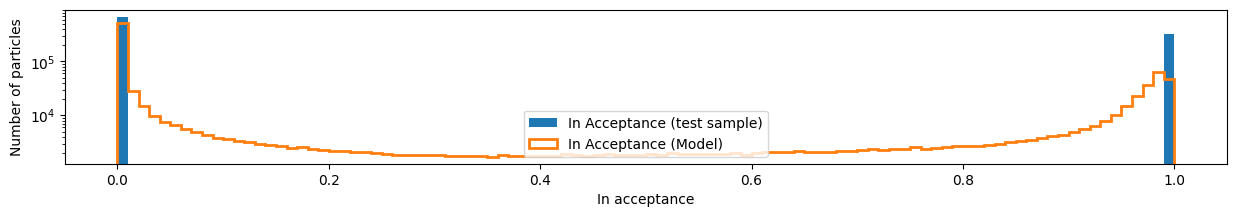

In [8]:
plt.figure(figsize=(15,2))
df = cdf.head(1_000_000, npartitions=-1)
plt.hist(df.acceptance, bins=np.linspace(0, 1, 101), label="In Acceptance (test sample)")
plt.hist(df.predicted_acceptance, bins=np.linspace(0, 1, 101), label="In Acceptance (Model)", histtype='step', linewidth=2)
plt.legend()
plt.xlabel("In acceptance")
plt.ylabel("Number of particles")
plt.yscale('log')
plt.show()

## Adding derived variables to the dataset

To build the histograms in kinematic bins we need may need to add some variable.
Using `dask` and `cudf`, the computation of these new variables is *lazy*: it is delayed to the time when the result is read.
At that point, the chunks are iteratively loaded from disk and the whole sequence of operations is performed on each chunk.

In [9]:
def compute_momentum(df):
    df['mc_p'] = 10**df['mc_log10_p']
    df['mc_pz'] = (df.mc_p**2 / (1 + df.mc_tx**2 + df.mc_ty**2))**0.5
    df['mc_px'] = df.mc_pz * df.mc_tx
    df['mc_py'] = df.mc_pz * df.mc_ty
    df['mc_pt'] = (df.mc_px**2 + df.mc_py**2)**0.5
    return df

def compute_eta(df):    
    mc_theta = cp.arcsin(df.mc_pt/df.mc_p)
    df['mc_eta'] = -cp.log(cp.tan(mc_theta/2))
    return df

def compute_phi(df):
    df['mc_phi'] = cp.arctan2(df.mc_py, df.mc_px)
    return df
    

cdf = (cdf.map_partitions(compute_momentum)
      #  .map_partitions(compute_eta)
      #  .map_partitions(compute_phi)
      )

## Acceptance histograms in momentum and pseudorapidity bins

Here we report the comparison of the distribution of events:
<UL>
<LI> <SPAN style="color: blue;" > Generated (without cuts or requirements) </SPAN>
<LI> <SPAN style="color: orange;" > Selected, or "in acceptance (true)" <SPAN>
<LI> <SPAN style="color: green;" > Weighted, or "in acceptance (predicted)" </SPAN>
</UL>

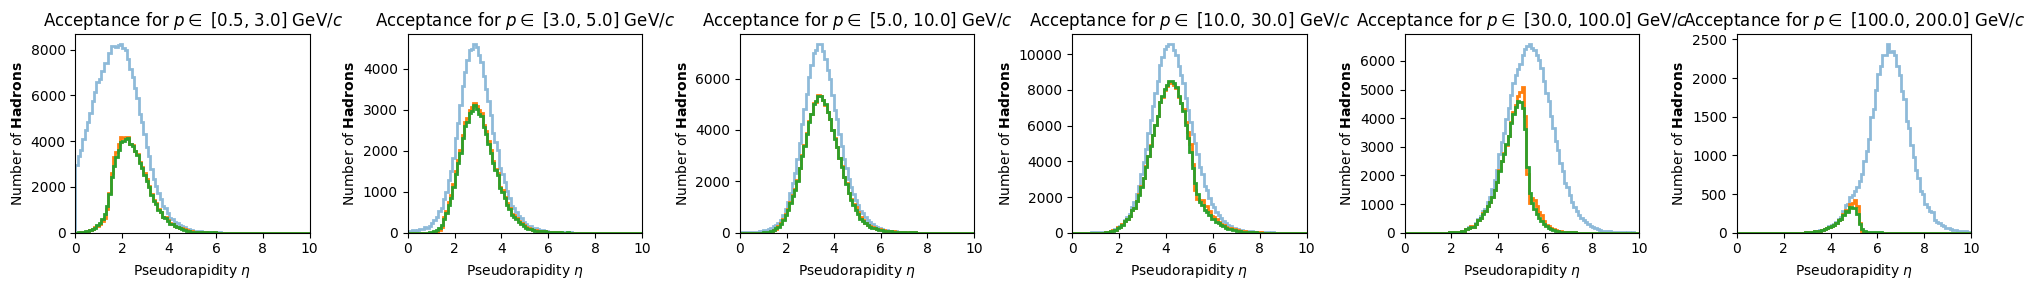

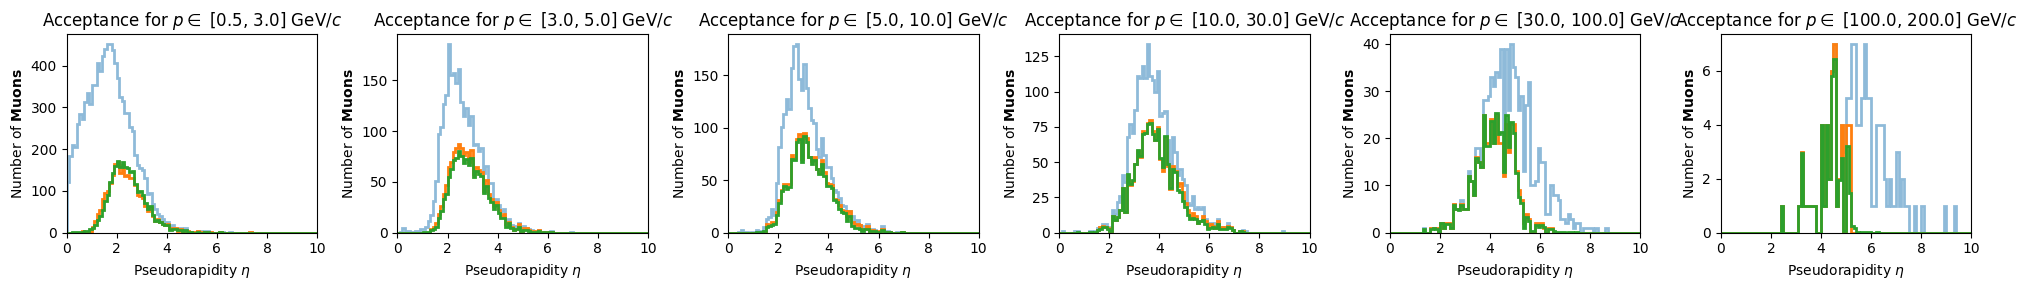

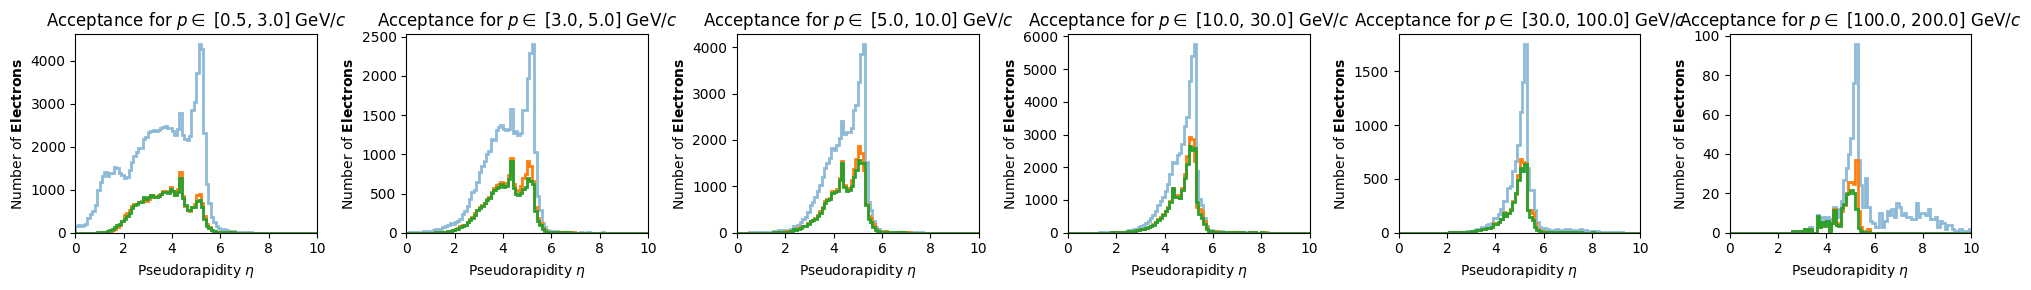

In [10]:
p_boundaries = [500, 3_000, 5_000, 10_000, 30_000, 100_000, 200_000]

retain = ['acceptance', 'predicted_acceptance', 'mc_eta', 'mc_log10_p']

for part in ['h', 'mu', 'e']:
    part_df = cdf.query(f"mc_is_{part} == 1 and mc_eta > 0 and mc_eta < 12")[retain].compute()
    
    plt.figure(figsize=(20,3))
    for iPlot, (p_min, p_max) in enumerate(zip(p_boundaries[:-1], p_boundaries[1:]), 1):
        plt.subplot(1, len(p_boundaries)-1, iPlot)
        bin_df = part_df.query(f"mc_log10_p > {np.log10(p_min)} and mc_log10_p < {np.log10(p_max)}")
        denominator, bins = cp.histogram(bin_df.mc_eta.values, bins=np.linspace(0, 10, 101))
        true_numerator, _ = cp.histogram(bin_df.query('acceptance==1').mc_eta.values, bins=bins)
        pred_numerator,_ = cp.histogram(bin_df.mc_eta.values, weights=bin_df.predicted_acceptance.values, bins=bins)
    
        bins = bins.get()
        x = (bins[:-1] + bins[1:])/2
        plt.hist(x, bins=bins, weights=denominator.get(), histtype='step', linewidth=2, alpha=0.5, label="Generated")
        plt.hist(x, bins=bins, weights=true_numerator.get(), histtype='step', linewidth=2, label="In acceptance (true)")
        plt.hist(x, bins=bins, weights=pred_numerator.get(), histtype='step', linewidth=2, label="In acceptance (model)")
        plt.xlim(bins[0], bins[-1])

        part_name = dict(h="Hadrons", mu='Muons', e='Electrons')[part]
        plt.title(f"Acceptance for $p \in$ [{p_min/1e3:.1f}, {p_max/1e3:.1f}] GeV/$c$")
        plt.xlabel("Pseudorapidity $\eta$")
        plt.ylabel(f"Number of $\mathbf{{{part_name}}}$")
        plt.tight_layout()
    plt.show()

## Acceptance histograms in momentum and polar angle bins

Here we report the comparison of the distribution of events:
<UL>
<LI> <SPAN style="color: blue;" > Generated (without cuts or requirements) </SPAN>
<LI> <SPAN style="color: orange;" > Selected, or "in acceptance (true)" <SPAN>
<LI> <SPAN style="color: green;" > Weighted, or "in acceptance (predicted)" </SPAN>
</UL>

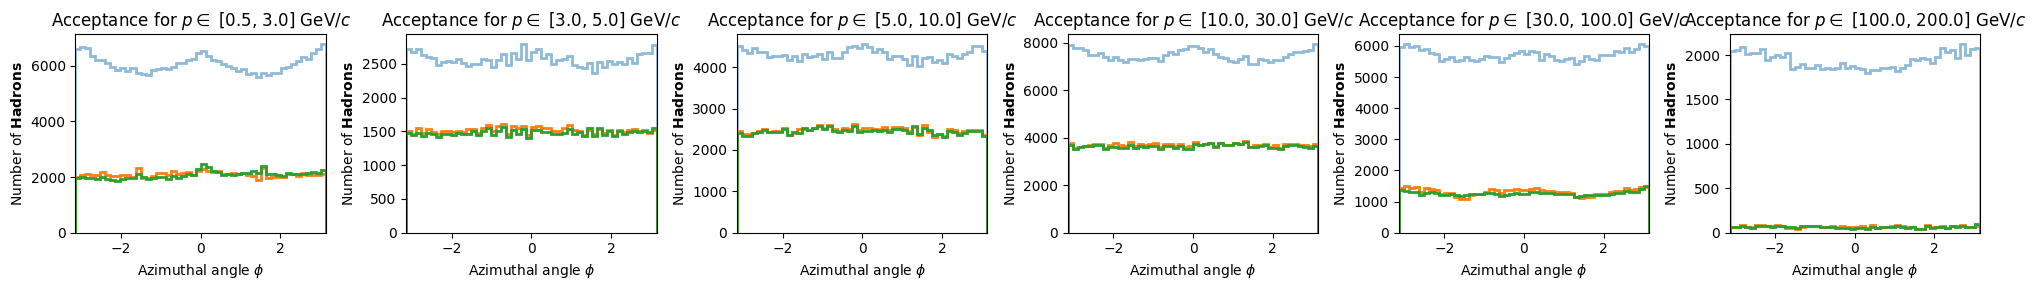

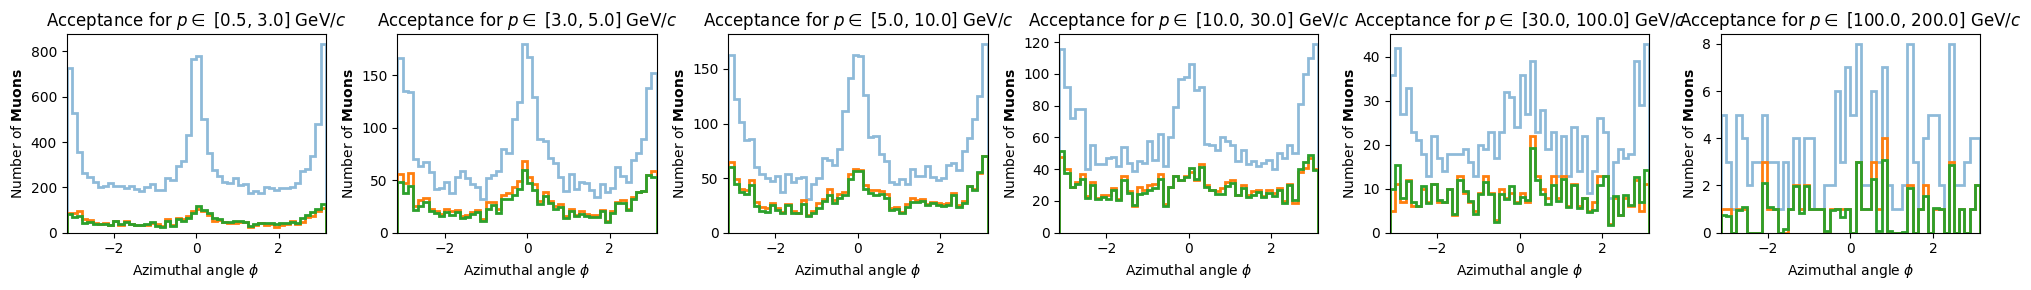

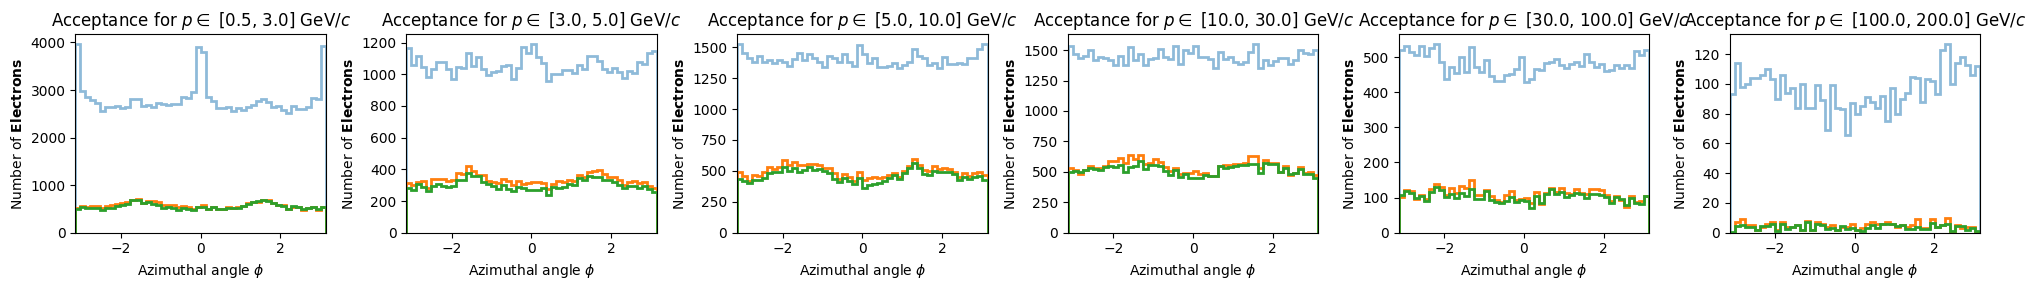

In [11]:
p_boundaries = [500, 3_000, 5_000, 10_000, 30_000, 100_000, 200_000]

retain = ['acceptance', 'predicted_acceptance', 'mc_phi', 'mc_log10_p']

for part in ['h', 'mu', 'e']:
    part_df = cdf.query(f"mc_is_{part} == 1 and mc_phi > -3.5 and mc_phi < 3.5")[retain].compute()
    
    plt.figure(figsize=(20,3))
    for iPlot, (p_min, p_max) in enumerate(zip(p_boundaries[:-1], p_boundaries[1:]), 1):
        plt.subplot(1, len(p_boundaries)-1, iPlot)
        bin_df = part_df.query(f"mc_log10_p > {np.log10(p_min)} and mc_log10_p < {np.log10(p_max)}")
        denominator, bins = cp.histogram(bin_df.mc_phi.values, bins=np.linspace(-np.pi, np.pi, 51))
        true_numerator, _ = cp.histogram(bin_df.query('acceptance==1').mc_phi.values, bins=bins)
        pred_numerator,_ = cp.histogram(bin_df.mc_phi.values, weights=bin_df.predicted_acceptance.values, bins=bins)
    
        bins = bins.get()
        x = (bins[:-1] + bins[1:])/2
        plt.hist(x, bins=bins, weights=denominator.get(), histtype='step', linewidth=2, alpha=0.5, label="Generated")
        plt.hist(x, bins=bins, weights=true_numerator.get(), histtype='step', linewidth=2, label="In acceptance (true)")
        plt.hist(x, bins=bins, weights=pred_numerator.get(), histtype='step', linewidth=2, label="In acceptance (model)")
        plt.xlim(bins[0], bins[-1])

        part_name = dict(h="Hadrons", mu='Muons', e='Electrons')[part]
        plt.title(f"Acceptance for $p \in$ [{p_min/1e3:.1f}, {p_max/1e3:.1f}] GeV/$c$")
        plt.xlabel("Azimuthal angle $\phi$")
        plt.ylabel(f"Number of $\mathbf{{{part_name}}}$")
        plt.tight_layout()
    plt.show()

## Conclusion 

In this notebook we produced some plots showing the agreement between the acceptance obtained from detailed simulation and the modeled acceptance probability.

Additional comparisons and plots might be added in the future.

In [12]:
### export notebooks for comparisons
if environ.get('NB_EXPORT',"False")=="True":
    import os
    nb_save  = "/workarea/local/shared/scapelli/notebooks_exports"         # export output dir
    nb_save  = nb_save+environ['TRAINING_DATA_FOLDER']                     # according to train data
    if environ['MODEL_VARIANT'] != '':
        nb_save  = os.path.join(nb_save,environ['MODEL_VARIANT'])          # according to model variant
    if not os.path.isdir(nb_save): os.makedirs(nb_save)                    # create if not exists
    nbs_path = "/workarea/local/shared/scapelli/lb-trksim-train/notebooks" # notebooks folder
    nb_filename = "Acceptance-validation.ipynb"                            # notebook name
    extensions  = ["html","pdf"]                                           # export formats
    for ext in extensions:
        os.system("jupyter nbconvert --log-level=40 --no-input --output-dir {0} --to {1} {2}/{3}".format(nb_save,ext.upper(),nbs_path,nb_filename))
    print("Exported {} as {} in {}".format(nb_filename,','.join(extensions),nb_save))

Exported Acceptance-validation.ipynb as html,pdf in /workarea/local/shared/scapelli/notebooks_exports/j100/v1
